In [1]:
import numpy as np
import torch
from cmb_ps import CMBPS, unnormalize_phi, normalize_phi
import matplotlib.pyplot as plt
from hmc_torch import HMC

In [2]:
device = 0

def sample_prior(n):
    """
    Sample from the (normalized) prior distribution.
    phi = (H0, Obh2) with H0 ~ U(0, 1), Obh2 ~ U(0, 1)
    (unnormalized prior is H0 ~ U(50, 90), Obh2 ~ U(0.0075, 0.0567))
    """
    phi = torch.rand(n, 2).to(device)
    return phi

ps_model = CMBPS(norm_phi=True).to(device)
phi_test = normalize_phi(torch.tensor([70, 32.1e-3]).to(device))
print("Normalized test phi:", phi_test)
ps_test = ps_model(phi_test)
x_test = torch.fft.ifft2(torch.fft.fft2(torch.randn((256, 256), device=device))*torch.sqrt(ps_test)).real

def log_likelihood(phi, x):
    """
    Compute the log likelihood of the Gaussian model.
    """
    x_dim = x.shape[-1]*x.shape[-2]

    ps = ps_model(phi).to(device)
    xf = torch.fft.fft2(x)

    term_pi = -(x_dim/2) * np.log(2*np.pi)
    term_logdet = -1/2*torch.sum(torch.log(ps), dim=(-1, -2)) # The determinant is the product of the diagonal elements of the PS
    term_x = -1/2*torch.sum(1/ps*torch.abs(xf)**2, dim=(-1, -2))/x_dim # We divide by x_dim because of the normalization of the FFT

    return term_pi + term_logdet + term_x

def log_prior(phi):
    """
    Compute the log (normalized) prior of the parameters.
    """
    H0, Obh2 = phi[..., 0], phi[..., 1]
    term_H0 = torch.log(torch.logical_and(H0 >= 0.0, H0 <= 1.0).float()) #gives either 0 or -inf
    term_Obh2 = torch.log(torch.logical_and(Obh2 >= 0.0, Obh2 <= 1.0).float()) #gives either 0 or -inf
    return term_H0 + term_Obh2

def log_posterior(phi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(phi, x) + log_prior(phi)

Normalized test phi: tensor([0.5000, 0.5000], device='cuda:0')


In [3]:
log_prob = lambda phi: log_posterior(phi, x_test)

def log_prob_grad(phi):
    """
    Compute the log posterior and its gradient.
    """
    phi.requires_grad_(True)
    log_prob = log_posterior(phi, x_test)
    grad_log_prob = torch.autograd.grad(log_prob, phi, grad_outputs=torch.ones_like(log_prob))[0]
    phi.requires_grad_(False)
    return log_prob.detach(), grad_log_prob

In [4]:
hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)

kwargs = {'nsamples': 200,
          'burnin': 20,
          'step_size': 0.001,
          'nleap': 30}

nchains = 20
phi_0 = sample_prior(nchains)
sampler = hmc.sample(phi_0, **kwargs)

  0%|          | 0/220 [00:00<?, ?it/s]

100%|██████████| 220/220 [05:01<00:00,  1.37s/it]


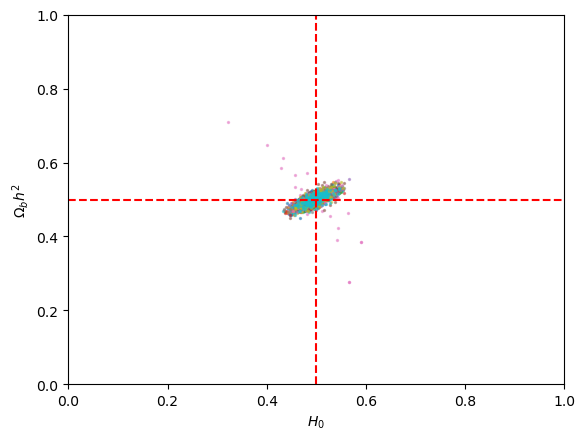

In [5]:
plt.figure()
for i in range(nchains):
    plt.scatter(sampler.samples[i, :, 0].detach().cpu().numpy(), sampler.samples[i, :, 1].detach().cpu().numpy(), s=2, alpha=0.5)
plt.axvline(phi_test[0].detach().cpu().numpy(), color='red', linestyle='--')
plt.axhline(phi_test[1].detach().cpu().numpy(), color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

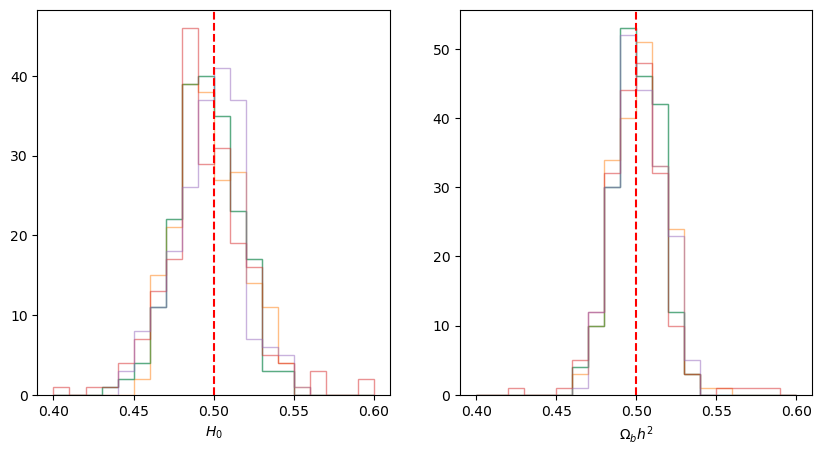

In [6]:
chains_id = np.random.randint(0, nchains, 5)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in chains_id:
    axs[0].hist(sampler.samples[i, :, 0].detach().cpu().numpy(), alpha=0.5, bins=20, range=(0.4, 0.6), histtype='step')
    axs[1].hist(sampler.samples[i, :, 1].detach().cpu().numpy(), alpha=0.5, bins=20, range=(0.4, 0.6), histtype='step')
axs[0].axvline(phi_test[0].detach().cpu().numpy(), color='red', linestyle='--')
axs[1].axvline(phi_test[1].detach().cpu().numpy(), color='red', linestyle='--')
axs[0].set_xlabel(r"$H_0$")
axs[1].set_xlabel(r"$\Omega_b h^2$")
plt.show()